# 📊 RSI Scanner Dashboard - Comprehensive Analysis

**Daily S&P 500 Stock Scanner with RSI/ATR Analysis**

This notebook provides comprehensive filtering and analysis of the daily scan results, highlighting:
- 🔴 Extreme overbought/oversold conditions
- ⚡ Overextended stocks beyond thresholds
- 📈 Trading opportunities (Long PUT/CALL setups)
- 💹 Volatility analysis
- 🎯 Top priority trades

**Data Source:** `data/exports/daily_scan_results.csv`

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully!
📅 Analysis Date: 2025-11-12 12:38:16


## 📁 Load and Inspect Dataset

In [ ]:
# Load the daily scan results
df = pd.read_csv('data/exports/daily_scan_results.csv')

# Display basic information
print("=" * 80)
print("📊 DATASET OVERVIEW")
print("=" * 80)
print(f"\n📏 Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"📅 Scan Date: {df['scan_date'].iloc[0]}")
print(f"🕐 Last Updated: {df['scan_timestamp'].iloc[0]}")

print("\n" + "=" * 80)
print("📋 COLUMN INFORMATION")
print("=" * 80)
print(df.dtypes)

print("\n" + "=" * 80)
print("📊 BASIC STATISTICS")
print("=" * 80)
print(df[['price', 'rsi', 'atr', 'atr_pct']].describe())

print("\n" + "=" * 80)
print("⚠️ MISSING VALUES")
print("=" * 80)
missing = df.isnull().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print(missing)
else:
    print("✅ No missing values!")

# Display first few rows
print("\n" + "=" * 80)
print("👀 SAMPLE DATA (First 5 rows)")
print("=" * 80)
df.head()

📊 DATASET OVERVIEW

📏 Shape: 499 rows × 15 columns
📅 Scan Date: 2025-11-12
🕐 Last Updated: 2025-11-12 07:55:48

📋 COLUMN INFORMATION
scan_date                       object
symbol                          object
price                          float64
rsi                            float64
atr                            float64
atr_pct                        float64
is_overextended                  int64
threshold                      float64
swing_low                      float64
distance_from_threshold_pct    float64
signal                          object
suggested_trade                 object
priority                         int64
created_at                      object
scan_timestamp                  object
dtype: object

📊 BASIC STATISTICS
        price    rsi    atr  atr_pct
count  499.00 499.00 499.00   499.00
mean   226.79  53.05   6.18     2.77
std    467.48  15.63  11.62     0.99
min      8.46  10.96   0.19     0.23
25%     71.24  42.29   1.73     2.12
50%    132.31  53.42   3.4

,scan_date,symbol,price,rsi,atr,atr_pct,is_overextended,threshold,swing_low,distance_from_threshold_pct,signal,suggested_trade,priority,created_at,scan_timestamp
0,2025-11-12,HOLX,74.60,93.81,0.83,1.12,0,78.12,73.96,NaN,Extreme Overbought,LONG PUT,1,2025-11-12 13:43:35,2025-11-12 07:55:48
1,2025-11-12,CAH,204.81,93.39,5.15,2.52,0,215.47,189.70,NaN,Extreme Overbought,LONG PUT,1,2025-11-12 13:42:34,2025-11-12 07:55:48
2,2025-11-12,LVS,66.99,91.72,2.12,3.17,0,70.94,60.32,NaN,Extreme Overbought,LONG PUT,1,2025-11-12 13:44:03,2025-11-12 07:55:48
3,2025-11-12,COR,365.08,88.17,7.76,2.13,0,374.72,335.90,NaN,Overbought,NaN,2,2025-11-12 13:42:46,2025-11-12 07:55:48
4,2025-11-12,DD,40.40,87.83,1.11,2.75,1,39.64,34.08,1.87,Overbought,LONG PUT,2,2025-11-12 13:42:56,2025-11-12 07:55:48


## 🔧 Define Filter Functions

Core filtering functions for efficient data analysis

In [ ]:
# Core Filter Functions
class ScannerFilters:
    """Comprehensive filtering functions for scanner data"""
    
    @staticmethod
    def filter_by_rsi_range(df, min_rsi=None, max_rsi=None):
        """Filter stocks by RSI range"""
        result = df.copy()
        if min_rsi is not None:
            result = result[result['rsi'] >= min_rsi]
        if max_rsi is not None:
            result = result[result['rsi'] <= max_rsi]
        return result
    
    @staticmethod
    def filter_by_signal(df, signal):
        """Filter by signal type"""
        return df[df['signal'] == signal]
    
    @staticmethod
    def filter_by_trade_type(df, trade_type):
        """Filter by suggested trade type"""
        return df[df['suggested_trade'] == trade_type]
    
    @staticmethod
    def filter_overextended(df, only_overextended=True):
        """Filter overextended stocks"""
        if only_overextended:
            return df[df['is_overextended'] == 1]
        return df[df['is_overextended'] == 0]
    
    @staticmethod
    def filter_by_volatility(df, min_atr_pct=None, max_atr_pct=None):
        """Filter by ATR percentage (volatility)"""
        result = df.copy()
        if min_atr_pct is not None:
            result = result[result['atr_pct'] >= min_atr_pct]
        if max_atr_pct is not None:
            result = result[result['atr_pct'] <= max_atr_pct]
        return result
    
    @staticmethod
    def filter_by_price_range(df, min_price=None, max_price=None):
        """Filter by price range"""
        result = df.copy()
        if min_price is not None:
            result = result[result['price'] >= min_price]
        if max_price is not None:
            result = result[result['price'] <= max_price]
        return result
    
    @staticmethod
    def filter_by_priority(df, max_priority):
        """Filter by priority level (1 = highest)"""
        return df[df['priority'] <= max_priority]
    
    @staticmethod
    def filter_symbols(df, symbols):
        """Filter specific symbols"""
        return df[df['symbol'].isin(symbols)]
    
    @staticmethod
    def combine_filters(df, **filters):
        """Combine multiple filters using AND logic"""
        result = df.copy()
        
        if 'min_rsi' in filters or 'max_rsi' in filters:
            result = ScannerFilters.filter_by_rsi_range(
                result, 
                filters.get('min_rsi'), 
                filters.get('max_rsi')
            )
        
        if 'signal' in filters:
            result = ScannerFilters.filter_by_signal(result, filters['signal'])
        
        if 'trade_type' in filters:
            result = ScannerFilters.filter_by_trade_type(result, filters['trade_type'])
        
        if 'overextended' in filters:
            result = ScannerFilters.filter_overextended(result, filters['overextended'])
        
        if 'min_atr_pct' in filters or 'max_atr_pct' in filters:
            result = ScannerFilters.filter_by_volatility(
                result,
                filters.get('min_atr_pct'),
                filters.get('max_atr_pct')
            )
        
        if 'min_price' in filters or 'max_price' in filters:
            result = ScannerFilters.filter_by_price_range(
                result,
                filters.get('min_price'),
                filters.get('max_price')
            )
        
        if 'max_priority' in filters:
            result = ScannerFilters.filter_by_priority(result, filters['max_priority'])
        
        return result

print("✅ Filter functions defined!")

✅ Filter functions defined!


## 🎯 Key Trading Opportunity Variables

Pre-filtered datasets for quick analysis

In [ ]:
# Install and import widgets for interactive filtering
import ipywidgets as widgets
from IPython.display import display, clear_output
import json

# Create Interactive Filter Widget
class InteractiveFilter:
    def __init__(self, dataframe):
        self.df = dataframe
        self.filtered_df = dataframe.copy()
        self.create_widgets()
        self.create_output()
    
    def create_widgets(self):
        # RSI Range Filter
        self.rsi_range = widgets.IntRangeSlider(
            value=[0, 100],
            min=0, max=100,
            step=1,
            description='RSI Range:',
            style={'description_width': 'initial'}
        )
        
        # Signal Filter
        signals = ['All'] + list(self.df['signal'].unique())
        self.signal_dropdown = widgets.Dropdown(
            options=signals,
            value='All',
            description='Signal:',
        )
        
        # Trade Type Filter
        trades = ['All'] + [t for t in self.df['suggested_trade'].unique() if pd.notna(t)]
        self.trade_dropdown = widgets.Dropdown(
            options=trades,
            value='All',
            description='Trade Type:',
        )
        
        # Priority Filter
        self.priority_select = widgets.SelectMultiple(
            options=[1, 2, 3],
            value=[1, 2, 3],
            description='Priority:',
        )
        
        # Price Range Filter
        self.price_range = widgets.FloatRangeSlider(
            value=[self.df['price'].min(), self.df['price'].max()],
            min=self.df['price'].min(),
            max=self.df['price'].max(),
            step=1.0,
            description='Price Range:',
            style={'description_width': 'initial'}
        )
        
        # ATR % Filter
        self.atr_range = widgets.FloatRangeSlider(
            value=[0, 10],
            min=0, max=10,
            step=0.1,
            description='ATR % Range:',
            style={'description_width': 'initial'}
        )
        
        # Overextended Toggle
        self.overextended_toggle = widgets.Checkbox(
            value=False,
            description='Only Overextended',
        )
        
        # Quick Filter Buttons
        self.quick_filters = widgets.HBox([
            widgets.Button(description='🔴 Extreme Overbought', button_style='danger'),
            widgets.Button(description='⚡ Overextended', button_style='warning'),
            widgets.Button(description='🟢 Oversold', button_style='success'),
            widgets.Button(description='🎯 Priority 1', button_style='info'),
            widgets.Button(description='💎 Best Setups', button_style='primary'),
            widgets.Button(description='🔄 Reset All', button_style=''),
        ])
        
        # Apply and Save buttons
        self.action_buttons = widgets.HBox([
            widgets.Button(description='Apply Filters', button_style='primary'),
            widgets.Button(description='Save Filter', button_style='success'),
            widgets.Button(description='Load Filter', button_style='info'),
        ])
        
        # Connect event handlers
        self.setup_event_handlers()
    
    def setup_event_handlers(self):
        # Connect all widgets to update function
        for widget in [self.rsi_range, self.signal_dropdown, self.trade_dropdown, 
                      self.priority_select, self.price_range, self.atr_range, self.overextended_toggle]:
            widget.observe(self.on_filter_change, names='value')
        
        # Quick filter buttons
        buttons = self.quick_filters.children
        buttons[0].on_click(lambda b: self.apply_quick_filter('extreme_overbought'))  # Extreme Overbought
        buttons[1].on_click(lambda b: self.apply_quick_filter('overextended'))        # Overextended
        buttons[2].on_click(lambda b: self.apply_quick_filter('oversold'))            # Oversold
        buttons[3].on_click(lambda b: self.apply_quick_filter('priority_1'))          # Priority 1
        buttons[4].on_click(lambda b: self.apply_quick_filter('best_setups'))         # Best Setups
        buttons[5].on_click(lambda b: self.reset_filters())                           # Reset
        
        # Action buttons
        action_buttons = self.action_buttons.children
        action_buttons[0].on_click(lambda b: self.apply_filters())     # Apply
        action_buttons[1].on_click(lambda b: self.save_filter())       # Save
        action_buttons[2].on_click(lambda b: self.load_filter())       # Load
    
    def apply_quick_filter(self, filter_type):
        if filter_type == 'extreme_overbought':
            self.rsi_range.value = [90, 100]
            self.signal_dropdown.value = 'All'
        elif filter_type == 'overextended':
            self.overextended_toggle.value = True
        elif filter_type == 'oversold':
            self.rsi_range.value = [10, 30]
            self.signal_dropdown.value = 'All'
        elif filter_type == 'priority_1':
            self.priority_select.value = [1]
        elif filter_type == 'best_setups':
            self.priority_select.value = [1, 2]
            self.atr_range.value = [2.0, 5.0]
        
        self.apply_filters()
    
    def reset_filters(self):
        self.rsi_range.value = [0, 100]
        self.signal_dropdown.value = 'All'
        self.trade_dropdown.value = 'All'
        self.priority_select.value = [1, 2, 3]
        self.price_range.value = [self.df['price'].min(), self.df['price'].max()]
        self.atr_range.value = [0, 10]
        self.overextended_toggle.value = False
        self.apply_filters()
    
    def on_filter_change(self, change):
        self.apply_filters()
    
    def apply_filters(self):
        # Start with full dataset
        filtered = self.df.copy()
        
        # Apply RSI filter
        min_rsi, max_rsi = self.rsi_range.value
        filtered = filtered[(filtered['rsi'] >= min_rsi) & (filtered['rsi'] <= max_rsi)]
        
        # Apply signal filter
        if self.signal_dropdown.value != 'All':
            filtered = filtered[filtered['signal'] == self.signal_dropdown.value]
        
        # Apply trade type filter
        if self.trade_dropdown.value != 'All':
            filtered = filtered[filtered['suggested_trade'] == self.trade_dropdown.value]
        
        # Apply priority filter
        filtered = filtered[filtered['priority'].isin(self.priority_select.value)]
        
        # Apply price filter
        min_price, max_price = self.price_range.value
        filtered = filtered[(filtered['price'] >= min_price) & (filtered['price'] <= max_price)]
        
        # Apply ATR filter
        min_atr, max_atr = self.atr_range.value
        filtered = filtered[(filtered['atr_pct'] >= min_atr) & (filtered['atr_pct'] <= max_atr)]
        
        # Apply overextended filter
        if self.overextended_toggle.value:
            filtered = filtered[filtered['is_overextended'] == 1]
        
        self.filtered_df = filtered
        self.display_results()
    
    def display_results(self):
        with self.output:
            clear_output(wait=True)
            print(f"📊 FILTERED RESULTS: {len(self.filtered_df)} stocks")
            print("=" * 80)
            
            if len(self.filtered_df) > 0:
                # Show top results
                display_cols = ['symbol', 'price', 'rsi', 'atr_pct', 'signal', 'suggested_trade', 'priority']
                top_results = self.filtered_df[display_cols].head(20)
                print(top_results.to_string(index=False))
                
                # Quick stats
                print(f"\n📈 QUICK STATS:")
                print(f"   Mean RSI: {self.filtered_df['rsi'].mean():.1f}")
                print(f"   Mean ATR%: {self.filtered_df['atr_pct'].mean():.1f}%")
                print(f"   Mean Price: ${self.filtered_df['price'].mean():.2f}")
                
                # Export button
                print(f"\n💾 To export: run export_filtered_results()")
                
            else:
                print("No stocks match your filter criteria.")
                print("Try adjusting the filters above.")
    
    def save_filter(self):
        """Save current filter settings"""
        settings = {
            'rsi_range': list(self.rsi_range.value),
            'signal': self.signal_dropdown.value,
            'trade_type': self.trade_dropdown.value,
            'priority': list(self.priority_select.value),
            'price_range': list(self.price_range.value),
            'atr_range': list(self.atr_range.value),
            'overextended': self.overextended_toggle.value
        }
        
        # Save to file
        import os
        os.makedirs('data/exports/saved_filters', exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f'data/exports/saved_filters/filter_{timestamp}.json'
        
        with open(filename, 'w') as f:
            json.dump(settings, f, indent=2)
        
        print(f"✅ Filter saved to: {filename}")
    
    def load_filter(self):
        """Load most recent filter settings"""
        import os
        filter_dir = 'data/exports/saved_filters'
        if os.path.exists(filter_dir):
            files = [f for f in os.listdir(filter_dir) if f.endswith('.json')]
            if files:
                latest = sorted(files)[-1]
                filepath = os.path.join(filter_dir, latest)
                
                with open(filepath, 'r') as f:
                    settings = json.load(f)
                
                # Apply settings
                self.rsi_range.value = settings.get('rsi_range', [0, 100])
                self.signal_dropdown.value = settings.get('signal', 'All')
                self.trade_dropdown.value = settings.get('trade_type', 'All')
                self.priority_select.value = settings.get('priority', [1, 2, 3])
                self.price_range.value = settings.get('price_range', [0, 1000])
                self.atr_range.value = settings.get('atr_range', [0, 10])
                self.overextended_toggle.value = settings.get('overextended', False)
                
                print(f"✅ Filter loaded from: {filepath}")
                self.apply_filters()
            else:
                print("⚠️ No saved filters found")
        else:
            print("⚠️ No saved filters directory found")
    
    def create_output(self):
        self.output = widgets.Output()
    
    def display(self):
        # Layout all widgets
        filter_controls = widgets.VBox([
            widgets.HTML("<h3>🎛️ Interactive Filters</h3>"),
            self.rsi_range,
            widgets.HBox([self.signal_dropdown, self.trade_dropdown]),
            widgets.HBox([self.priority_select, self.overextended_toggle]),
            self.price_range,
            self.atr_range,
            widgets.HTML("<h4>Quick Filters:</h4>"),
            self.quick_filters,
            widgets.HTML("<h4>Actions:</h4>"),
            self.action_buttons,
        ])
        
        # Display everything
        display(filter_controls)
        display(self.output)
        
        # Initial filter application
        self.apply_filters()

# Function to export filtered results
def export_filtered_results():
    """Export the currently filtered results"""
    if 'filter_widget' in globals() and hasattr(filter_widget, 'filtered_df'):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f'data/exports/filtered_results_{timestamp}.csv'
        filter_widget.filtered_df.to_csv(filename, index=False)
        print(f"✅ Exported {len(filter_widget.filtered_df)} rows to: {filename}")
    else:
        print("⚠️ No filter widget found. Run the cell below first.")

print("✅ Interactive filter system ready!")

✅ Interactive filter system ready!


In [ ]:
# Create and display the interactive filter
print("🎛️ Creating Interactive Filter Widget...")
filter_widget = InteractiveFilter(df)
filter_widget.display()

🎛️ Creating Interactive Filter Widget...


Output()

: 

: 

In [ ]:
# === BEARISH OPPORTUNITIES (LONG PUT) ===
extreme_overbought = ScannerFilters.filter_by_rsi_range(df, min_rsi=90)
overbought = ScannerFilters.filter_by_rsi_range(df, min_rsi=70, max_rsi=90)
overextended = ScannerFilters.filter_overextended(df, only_overextended=True)
long_put_setups = ScannerFilters.filter_by_trade_type(df, 'LONG PUT')

# === BULLISH OPPORTUNITIES (LONG CALL) ===
extreme_oversold = ScannerFilters.filter_by_rsi_range(df, max_rsi=10)
oversold = ScannerFilters.filter_by_rsi_range(df, min_rsi=10, max_rsi=30)
long_call_setups = ScannerFilters.filter_by_trade_type(df, 'LONG CALL')

# === PRIORITY TRADES ===
priority_1 = ScannerFilters.filter_by_priority(df, max_priority=1)  # Highest priority
priority_2 = ScannerFilters.filter_by_priority(df, max_priority=2)  # High priority

# === VOLATILITY BUCKETS ===
low_vol = ScannerFilters.filter_by_volatility(df, max_atr_pct=2.0)  # Low volatility
ideal_vol = ScannerFilters.filter_by_volatility(df, min_atr_pct=2.0, max_atr_pct=5.0)  # Ideal
high_vol = ScannerFilters.filter_by_volatility(df, min_atr_pct=5.0)  # High volatility

# === PRICE RANGES (for options liquidity) ===
under_50 = ScannerFilters.filter_by_price_range(df, max_price=50)
mid_range = ScannerFilters.filter_by_price_range(df, min_price=50, max_price=200)
over_200 = ScannerFilters.filter_by_price_range(df, min_price=200)  # Best options liquidity

# === COMBINED FILTERS (Best Setups) ===
best_put_setups = ScannerFilters.combine_filters(
    df,
    trade_type='LONG PUT',
    max_priority=2,
    min_atr_pct=2.0,
    max_atr_pct=5.0
)

best_call_setups = ScannerFilters.combine_filters(
    df,
    trade_type='LONG CALL',
    max_priority=2,
    min_atr_pct=2.0,
    max_atr_pct=5.0
)

# Print summary
print("=" * 80)
print("📊 TRADING OPPORTUNITY VARIABLES")
print("=" * 80)
print(f"\n🔴 BEARISH (LONG PUT):")
print(f"   Extreme Overbought (RSI≥90):    {len(extreme_overbought):3d} stocks")
print(f"   Overbought (RSI 70-90):         {len(overbought):3d} stocks")
print(f"   ⚡ Overextended:                 {len(overextended):3d} stocks")
print(f"   Total LONG PUT Setups:          {len(long_put_setups):3d} stocks")

print(f"\n🟢 BULLISH (LONG CALL):")
print(f"   Extreme Oversold (RSI≤10):      {len(extreme_oversold):3d} stocks")
print(f"   Oversold (RSI 10-30):           {len(oversold):3d} stocks")
print(f"   Total LONG CALL Setups:         {len(long_call_setups):3d} stocks")

print(f"\n🎯 PRIORITY LEVELS:")
print(f"   Priority 1 (Highest):           {len(priority_1):3d} stocks")
print(f"   Priority 1-2 (High):            {len(priority_2):3d} stocks")

print(f"\n💹 VOLATILITY:")
print(f"   Low Vol (ATR < 2%):             {len(low_vol):3d} stocks")
print(f"   Ideal Vol (ATR 2-5%):           {len(ideal_vol):3d} stocks")
print(f"   High Vol (ATR > 5%):            {len(high_vol):3d} stocks")

print(f"\n💰 PRICE RANGES:")
print(f"   Under $50:                      {len(under_50):3d} stocks")
print(f"   $50-$200:                       {len(mid_range):3d} stocks")
print(f"   Over $200 (Best liquidity):     {len(over_200):3d} stocks")

print(f"\n⭐ BEST SETUPS (Priority + Ideal Vol):")
print(f"   Best LONG PUT setups:           {len(best_put_setups):3d} stocks")
print(f"   Best LONG CALL setups:          {len(best_call_setups):3d} stocks")
print("=" * 80)

📊 TRADING OPPORTUNITY VARIABLES

🔴 BEARISH (LONG PUT):
   Extreme Overbought (RSI≥90):      3 stocks
   Overbought (RSI 70-90):          69 stocks
   ⚡ Overextended:                   7 stocks
   Total LONG PUT Setups:           10 stocks

🟢 BULLISH (LONG CALL):
   Extreme Oversold (RSI≤10):        0 stocks
   Oversold (RSI 10-30):            40 stocks
   Total LONG CALL Setups:          40 stocks

🎯 PRIORITY LEVELS:
   Priority 1 (Highest):             3 stocks
   Priority 1-2 (High):            113 stocks

💹 VOLATILITY:
   Low Vol (ATR < 2%):              95 stocks
   Ideal Vol (ATR 2-5%):           385 stocks
   High Vol (ATR > 5%):             22 stocks

💰 PRICE RANGES:
   Under $50:                       82 stocks
   $50-$200:                       252 stocks
   Over $200 (Best liquidity):     165 stocks

⭐ BEST SETUPS (Priority + Ideal Vol):
   Best LONG PUT setups:             9 stocks
   Best LONG CALL setups:           32 stocks


## 🏆 Top 10 Opportunities - Quick View

In [ ]:
# Top 10 LONG PUT Opportunities
print("=" * 100)
print("🔴 TOP 10 LONG PUT OPPORTUNITIES")
print("=" * 100)
top_puts = long_put_setups.nlargest(10, 'rsi')[['symbol', 'price', 'rsi', 'atr_pct', 
                                                   'is_overextended', 'signal', 'priority']]
print(top_puts.to_string(index=False))

print("\n" + "=" * 100)
print("🟢 TOP 10 LONG CALL OPPORTUNITIES")
print("=" * 100)
top_calls = long_call_setups.nsmallest(10, 'rsi')[['symbol', 'price', 'rsi', 'atr_pct', 
                                                      'signal', 'priority']]
print(top_calls.to_string(index=False))

print("\n" + "=" * 100)
print("⚡ ALL OVEREXTENDED STOCKS (Highest Priority)")
print("=" * 100)
if len(overextended) > 0:
    overext_display = overextended[['symbol', 'price', 'rsi', 'atr_pct', 'threshold', 
                                     'distance_from_threshold_pct']].sort_values('rsi', ascending=False)
    print(overext_display.to_string(index=False))
else:
    print("No overextended stocks found.")

🔴 TOP 10 LONG PUT OPPORTUNITIES
symbol  price   rsi  atr_pct  is_overextended             signal  priority
  HOLX  74.60 93.81     1.12                0 Extreme Overbought         1
   CAH 204.81 93.39     2.52                0 Extreme Overbought         1
   LVS  66.99 91.72     3.17                0 Extreme Overbought         1
    DD  40.40 87.83     2.75                1         Overbought         2
   STE 266.70 87.51     2.14                1         Overbought         2
  AMGN 338.45 82.82     2.38                1         Overbought         2
  AKAM  90.61 81.57     3.39                1         Overbought         2
  DDOG 197.86 78.15     4.05                1         Overbought         2
  EXPE 265.32 76.96     3.85                1         Overbought         2
   BDX 189.02 61.77     2.65                1            Neutral         2

🟢 TOP 10 LONG CALL OPPORTUNITIES
symbol  price   rsi  atr_pct   signal  priority
   CMG  29.81 10.96     4.37 Oversold         2
  GRMN 199.66

## 📊 Visualization Dashboard

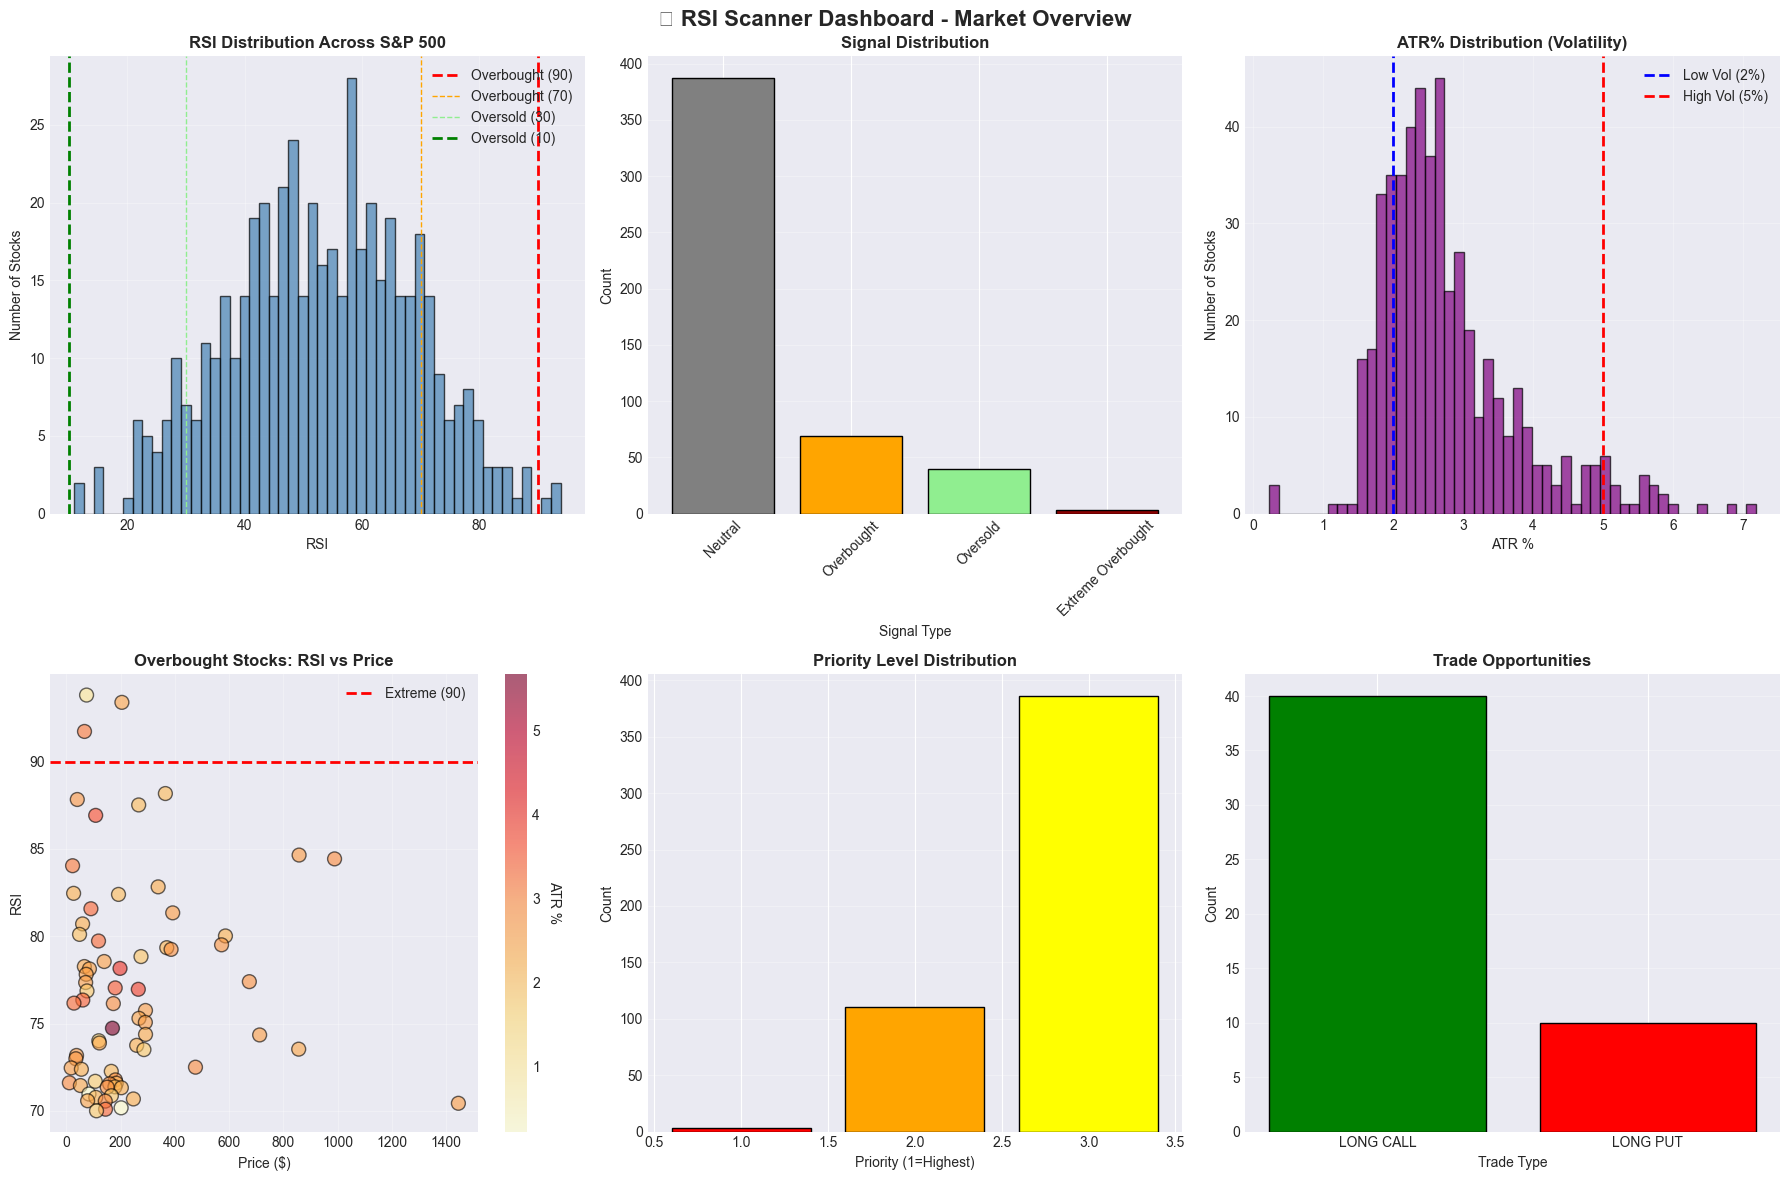

✅ Dashboard visualizations created!


In [ ]:
# Create comprehensive visualization dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('📊 RSI Scanner Dashboard - Market Overview', fontsize=16, fontweight='bold')

# 1. RSI Distribution
axes[0, 0].hist(df['rsi'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(90, color='red', linestyle='--', linewidth=2, label='Overbought (90)')
axes[0, 0].axvline(70, color='orange', linestyle='--', linewidth=1, label='Overbought (70)')
axes[0, 0].axvline(30, color='lightgreen', linestyle='--', linewidth=1, label='Oversold (30)')
axes[0, 0].axvline(10, color='green', linestyle='--', linewidth=2, label='Oversold (10)')
axes[0, 0].set_title('RSI Distribution Across S&P 500', fontweight='bold')
axes[0, 0].set_xlabel('RSI')
axes[0, 0].set_ylabel('Number of Stocks')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Signal Distribution
signal_counts = df['signal'].value_counts()
colors = {'Extreme Overbought': 'darkred', 'Overbought': 'orange', 
          'Neutral': 'gray', 'Oversold': 'lightgreen', 'Extreme Oversold': 'darkgreen'}
signal_colors = [colors.get(sig, 'gray') for sig in signal_counts.index]
axes[0, 1].bar(signal_counts.index, signal_counts.values, color=signal_colors, edgecolor='black')
axes[0, 1].set_title('Signal Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Signal Type')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. ATR% Distribution (Volatility)
axes[0, 2].hist(df['atr_pct'], bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[0, 2].axvline(2, color='blue', linestyle='--', linewidth=2, label='Low Vol (2%)')
axes[0, 2].axvline(5, color='red', linestyle='--', linewidth=2, label='High Vol (5%)')
axes[0, 2].set_title('ATR% Distribution (Volatility)', fontweight='bold')
axes[0, 2].set_xlabel('ATR %')
axes[0, 2].set_ylabel('Number of Stocks')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. RSI vs Price Scatter (Overbought stocks)
overbought_all = df[df['rsi'] >= 70]
axes[1, 0].scatter(overbought_all['price'], overbought_all['rsi'], 
                   c=overbought_all['atr_pct'], cmap='YlOrRd', s=100, alpha=0.6, edgecolors='black')
axes[1, 0].axhline(90, color='red', linestyle='--', linewidth=2, label='Extreme (90)')
axes[1, 0].set_title('Overbought Stocks: RSI vs Price', fontweight='bold')
axes[1, 0].set_xlabel('Price ($)')
axes[1, 0].set_ylabel('RSI')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0])
cbar.set_label('ATR %', rotation=270, labelpad=15)

# 5. Priority Distribution
priority_counts = df['priority'].value_counts().sort_index()
axes[1, 1].bar(priority_counts.index, priority_counts.values, 
               color=['red', 'orange', 'yellow', 'lightblue'], edgecolor='black')
axes[1, 1].set_title('Priority Level Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Priority (1=Highest)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6. Trade Opportunity Summary
trade_counts = df['suggested_trade'].value_counts()
colors_trade = {'LONG PUT': 'red', 'LONG CALL': 'green'}
trade_colors = [colors_trade.get(t, 'gray') for t in trade_counts.index]
axes[1, 2].bar(trade_counts.index, trade_counts.values, color=trade_colors, edgecolor='black')
axes[1, 2].set_title('Trade Opportunities', fontweight='bold')
axes[1, 2].set_xlabel('Trade Type')
axes[1, 2].set_ylabel('Count')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ Dashboard visualizations created!")

## 🔍 Detailed Analysis Tables

In [ ]:
# === BEST LONG PUT SETUPS ===
print("=" * 120)
print("🎯 BEST LONG PUT SETUPS (Priority 1-2 + Ideal Volatility)")
print("=" * 120)
if len(best_put_setups) > 0:
    display_cols = ['symbol', 'price', 'rsi', 'atr', 'atr_pct', 'is_overextended', 
                    'threshold', 'distance_from_threshold_pct', 'priority']
    best_puts_display = best_put_setups[display_cols].sort_values('rsi', ascending=False)
    print(best_puts_display.to_string(index=False))
else:
    print("No setups match criteria")

# === BEST LONG CALL SETUPS ===
print("\n" + "=" * 120)
print("🎯 BEST LONG CALL SETUPS (Priority 1-2 + Ideal Volatility)")
print("=" * 120)
if len(best_call_setups) > 0:
    display_cols = ['symbol', 'price', 'rsi', 'atr', 'atr_pct', 'swing_low', 'priority']
    best_calls_display = best_call_setups[display_cols].sort_values('rsi')
    print(best_calls_display.to_string(index=False))
else:
    print("No setups match criteria")

# === HIGH LIQUIDITY SETUPS (Price > $200) ===
print("\n" + "=" * 120)
print("💰 HIGH LIQUIDITY LONG PUT SETUPS (Price > $200 for best options market)")
print("=" * 120)
high_liquidity_puts = ScannerFilters.combine_filters(
    df,
    trade_type='LONG PUT',
    min_price=200,
    max_priority=2
)
if len(high_liquidity_puts) > 0:
    display_cols = ['symbol', 'price', 'rsi', 'atr_pct', 'is_overextended', 'priority']
    print(high_liquidity_puts[display_cols].sort_values('rsi', ascending=False).to_string(index=False))
else:
    print("No setups match criteria")

🎯 BEST LONG PUT SETUPS (Priority 1-2 + Ideal Volatility)
symbol  price   rsi   atr  atr_pct  is_overextended  threshold  distance_from_threshold_pct  priority
   CAH 204.81 93.39  5.15     2.52                0     215.47                          NaN         1
   LVS  66.99 91.72  2.12     3.17                0      70.94                          NaN         1
    DD  40.40 87.83  1.11     2.75                1      39.64                         1.87         2
   STE 266.70 87.51  5.71     2.14                1     264.53                         0.81         2
  AMGN 338.45 82.82  8.06     2.38                1     334.79                         1.08         2
  AKAM  90.61 81.57  3.07     3.39                1      86.16                         4.91         2
  DDOG 197.86 78.15  8.02     4.05                1     194.77                         1.56         2
  EXPE 265.32 76.96 10.21     3.85                1     259.50                         2.19         2
   BDX 189.02 61.77  5.01

## 📈 Statistical Summary

In [ ]:
# Statistical Summary
print("=" * 80)
print("📊 MARKET STATISTICS")
print("=" * 80)

# RSI Statistics
print("\n🔹 RSI STATISTICS:")
print(f"   Mean RSI:        {df['rsi'].mean():.2f}")
print(f"   Median RSI:      {df['rsi'].median():.2f}")
print(f"   Std Dev:         {df['rsi'].std():.2f}")
print(f"   Highest RSI:     {df['rsi'].max():.2f} ({df.loc[df['rsi'].idxmax(), 'symbol']})")
print(f"   Lowest RSI:      {df['rsi'].min():.2f} ({df.loc[df['rsi'].idxmin(), 'symbol']})")

# Volatility Statistics
print("\n🔹 VOLATILITY STATISTICS:")
print(f"   Mean ATR%:       {df['atr_pct'].mean():.2f}%")
print(f"   Median ATR%:     {df['atr_pct'].median():.2f}%")
print(f"   Highest ATR%:    {df['atr_pct'].max():.2f}% ({df.loc[df['atr_pct'].idxmax(), 'symbol']})")
print(f"   Lowest ATR%:     {df['atr_pct'].min():.2f}% ({df.loc[df['atr_pct'].idxmin(), 'symbol']})")

# Price Statistics
print("\n🔹 PRICE STATISTICS:")
print(f"   Mean Price:      ${df['price'].mean():.2f}")
print(f"   Median Price:    ${df['price'].median():.2f}")
print(f"   Highest Price:   ${df['price'].max():.2f} ({df.loc[df['price'].idxmax(), 'symbol']})")
print(f"   Lowest Price:    ${df['price'].min():.2f} ({df.loc[df['price'].idxmin(), 'symbol']})")

# Market Sentiment
print("\n🔹 MARKET SENTIMENT:")
bullish_pct = (len(df[df['rsi'] < 50]) / len(df)) * 100
bearish_pct = (len(df[df['rsi'] >= 50]) / len(df)) * 100
print(f"   Bullish (RSI<50): {bullish_pct:.1f}%")
print(f"   Bearish (RSI≥50): {bearish_pct:.1f}%")

if bullish_pct > 60:
    sentiment = "🟢 Market is OVERSOLD - Bullish opportunities"
elif bearish_pct > 60:
    sentiment = "🔴 Market is OVERBOUGHT - Bearish opportunities"
else:
    sentiment = "⚪ Market is NEUTRAL - Mixed signals"

print(f"   Overall:         {sentiment}")

print("=" * 80)

📊 MARKET STATISTICS

🔹 RSI STATISTICS:
   Mean RSI:        53.05
   Median RSI:      53.42
   Std Dev:         15.63
   Highest RSI:     93.81 (HOLX)
   Lowest RSI:      10.96 (CMG)

🔹 VOLATILITY STATISTICS:
   Mean ATR%:       2.77%
   Median ATR%:     2.54%
   Highest ATR%:    7.18% (SMCI)
   Lowest ATR%:     0.23% (K)

🔹 PRICE STATISTICS:
   Mean Price:      $226.79
   Median Price:    $132.31
   Highest Price:   $7301.21 (NVR)
   Lowest Price:    $8.46 (AMCR)

🔹 MARKET SENTIMENT:
   Bullish (RSI<50): 43.1%
   Bearish (RSI≥50): 56.9%
   Overall:         ⚪ Market is NEUTRAL - Mixed signals


## 💾 Export Functions

Export filtered results for further analysis

In [ ]:
# Export Functions
def export_opportunities(filename_suffix=''):
    """Export all key opportunity datasets"""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    export_dir = 'data/exports/notebook_exports'
    
    # Create export directory if it doesn't exist
    import os
    os.makedirs(export_dir, exist_ok=True)
    
    exports = {
        f'best_put_setups_{timestamp}{filename_suffix}.csv': best_put_setups,
        f'best_call_setups_{timestamp}{filename_suffix}.csv': best_call_setups,
        f'overextended_stocks_{timestamp}{filename_suffix}.csv': overextended,
        f'extreme_overbought_{timestamp}{filename_suffix}.csv': extreme_overbought,
        f'extreme_oversold_{timestamp}{filename_suffix}.csv': extreme_oversold,
    }
    
    print("=" * 80)
    print("💾 EXPORTING FILTERED RESULTS")
    print("=" * 80)
    
    for filename, data in exports.items():
        if len(data) > 0:
            filepath = f"{export_dir}/{filename}"
            data.to_csv(filepath, index=False)
            print(f"✅ Exported: {filepath} ({len(data)} rows)")
        else:
            print(f"⚠️  Skipped: {filename} (no data)")
    
    print("=" * 80)
    print(f"✅ All exports saved to: {export_dir}/")
    print("=" * 80)

# Example: Uncomment to export
# export_opportunities()

print("✅ Export functions ready!")
print("📝 To export, run: export_opportunities()")

✅ Export functions ready!
📝 To export, run: export_opportunities()


## 🎛️ Custom Filtering Examples

Use these examples to create your own custom filters

In [ ]:
# === EXAMPLE 1: Aggressive Overbought Plays (RSI 85-95, High Vol) ===
aggressive_puts = ScannerFilters.combine_filters(
    df,
    min_rsi=85,
    max_rsi=95,
    min_atr_pct=4.0,
    max_atr_pct=7.0
)
print("🔥 AGGRESSIVE OVERBOUGHT PLAYS (RSI 85-95, ATR 4-7%):")
print(f"   Found {len(aggressive_puts)} stocks")
if len(aggressive_puts) > 0:
    print(aggressive_puts[['symbol', 'price', 'rsi', 'atr_pct']].head(10))

# === EXAMPLE 2: Conservative Oversold Plays (RSI 15-25, Low Vol) ===
conservative_calls = ScannerFilters.combine_filters(
    df,
    min_rsi=15,
    max_rsi=25,
    min_atr_pct=1.5,
    max_atr_pct=3.0,
    min_price=100
)
print("\n🛡️ CONSERVATIVE OVERSOLD PLAYS (RSI 15-25, ATR 1.5-3%, Price>$100):")
print(f"   Found {len(conservative_calls)} stocks")
if len(conservative_calls) > 0:
    print(conservative_calls[['symbol', 'price', 'rsi', 'atr_pct']].head(10))

# === EXAMPLE 3: Mid-Cap Opportunities ($50-$200) ===
midcap_opportunities = ScannerFilters.combine_filters(
    df,
    min_price=50,
    max_price=200,
    max_priority=2
)
print("\n💼 MID-CAP OPPORTUNITIES ($50-$200, Priority 1-2):")
print(f"   Found {len(midcap_opportunities)} stocks")
if len(midcap_opportunities) > 0:
    print(midcap_opportunities[['symbol', 'price', 'rsi', 'suggested_trade']].head(10))

# === EXAMPLE 4: Custom Symbol Watchlist ===
watchlist = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'META']
watchlist_data = ScannerFilters.filter_symbols(df, watchlist)
print("\n👁️ CUSTOM WATCHLIST:")
print(f"   Tracking {len(watchlist_data)} stocks")
if len(watchlist_data) > 0:
    print(watchlist_data[['symbol', 'price', 'rsi', 'atr_pct', 'signal', 'suggested_trade']])

print("\n✅ Custom filter examples complete!")
print("💡 Tip: Modify these examples to create your own custom filters!")

🔥 AGGRESSIVE OVERBOUGHT PLAYS (RSI 85-95, ATR 4-7%):
   Found 0 stocks

🛡️ CONSERVATIVE OVERSOLD PLAYS (RSI 15-25, ATR 1.5-3%, Price>$100):
   Found 9 stocks
    symbol  price   rsi  atr_pct
93     DRI 171.59 24.50     2.24
95     LMT 457.07 24.42     2.17
97     CLX 105.03 23.26     2.50
99     ROP 443.27 23.23     2.51
101    ADP 255.20 22.13     1.92
103    MSI 391.96 21.77     2.14
105    PTC 178.00 21.22     2.57
108    ZTS 120.12 15.28     2.99
109   PAYX 111.64 15.16     2.31

💼 MID-CAP OPPORTUNITIES ($50-$200, Priority 1-2):
   Found 54 stocks
   symbol  price   rsi suggested_trade
0    HOLX  74.60 93.81        LONG PUT
2     LVS  66.99 91.72        LONG PUT
6    INCY 108.16 86.92             NaN
12   WELL 192.31 82.39             NaN
13   AKAM  90.61 81.57        LONG PUT
15    FOX  59.99 80.70             NaN
18    EXE 118.64 79.72             NaN
23   EXPD 139.51 78.55             NaN
24   FOXA  66.44 78.26             NaN
25   DDOG 197.86 78.15        LONG PUT

👁️ CUSTOM WA

## 📝 Quick Reference Guide

### Pre-Defined Variables Available:

**Bearish Opportunities (LONG PUT):**
- `extreme_overbought` - RSI ≥ 90
- `overbought` - RSI 70-90
- `overextended` - Beyond threshold (highest priority!)
- `long_put_setups` - All LONG PUT opportunities
- `best_put_setups` - Priority 1-2 + Ideal volatility

**Bullish Opportunities (LONG CALL):**
- `extreme_oversold` - RSI ≤ 10
- `oversold` - RSI 10-30
- `long_call_setups` - All LONG CALL opportunities
- `best_call_setups` - Priority 1-2 + Ideal volatility

**Priority Filters:**
- `priority_1` - Highest priority trades
- `priority_2` - High priority trades (1-2)

**Volatility Buckets:**
- `low_vol` - ATR < 2%
- `ideal_vol` - ATR 2-5% (sweet spot!)
- `high_vol` - ATR > 5%

**Price Ranges:**
- `under_50` - Under $50
- `mid_range` - $50-$200
- `over_200` - Over $200 (best options liquidity)

### Available Filter Functions:
```python
# Filter by RSI
ScannerFilters.filter_by_rsi_range(df, min_rsi=70, max_rsi=90)

# Filter by signal
ScannerFilters.filter_by_signal(df, 'Overbought')

# Filter overextended
ScannerFilters.filter_overextended(df, only_overextended=True)

# Filter by volatility
ScannerFilters.filter_by_volatility(df, min_atr_pct=2.0, max_atr_pct=5.0)

# Combine multiple filters
ScannerFilters.combine_filters(df, min_rsi=85, max_atr_pct=4.0, max_priority=2)
```